In [ ]:
%cd ~/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA

#Load outside module dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA


from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import umap

#Import local functions
%cd scripts/visualize_projection/
from pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
%matplotlib inline

%cd ../build_poincare_map
from poincare_maps import *
from embedding_quality_score import *

# Return to main directory
%cd ../../

/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA
/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA/scripts/visualize_projection
/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA/scripts/build_poincare_map
/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA


In [ ]:
#from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics
from sklearn.cluster import *

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5, class_exclude = "OTHER"): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        #clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
        #                                     affinity='precomputed').fit(D)
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
                                             affinity='precomputed').fit(D)
        labels = clustering.labels_
            
    return labels

/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA


Labels and number of clusters:

In [19]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0

out_name = "globins_data"
path_annotation = "examples/globins/globin_colors_new1.csv"
path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
print(df_embedding)
df_embedding.replace("Other", "OTHER")

FileNotFoundError: [Errno 2] No such file or directory: 'globins_data/projections/PM5sigma=1.00gamma=2.00cosinepca=0_seed0.csv'

In [ ]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
print(path_embedding)
model = PoincareMaps(poincare_coord)
model.get_distances()

# Comparison of different scores for Poincaré vs other methods

Prepare feature file for other methods.

In [4]:
n_proteins = df_embedding.shape[0]
x = np.array(np.loadtxt(out_name + "/fasta0.9/1.aamtx").reshape(-1))
len_prot = len(x)

features = np.zeros([n_proteins, len_prot])

for i in range(n_proteins):
    #print(out_name + "/fasta0.9/" + str(i) + ".aamtx")
    x = np.array(np.loadtxt(out_name + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
    features[i,:] = x


Calculate original distances:

In [5]:
D_raw = pairwise_distances(features, metric="cosine")
print(features[0,:])
print(D_raw.shape)

print(df_embedding.columns)

[0.1755 0.0183 0.2771 ... 0.0109 0.0768 0.0382]
(252, 252)
Index(['proteins_id', 'pm1', 'pm2', 'tree1', 'tree2', 'tree3', 'tree4',
       'full_name', 'short_name', 'full_species', 'short_species',
       'evo_distance', 'Color_species', 'Domain', 'Kingdom', 'Phylum',
       'Subphylum', 'Class', 'Genus'],
      dtype='object')


# SET PARAMETERS

In [72]:
df_results_clust = pd.DataFrame()

In [191]:
k_neigh = knn

# by names/family
true_col = "short_name"# "short_species"# 
other = "Uncharacterized" 

# by phylogenetic cluster
#true_col = "tree4"
#other = -1 

# by new annotation
#true_col = "Phylum"
#other = "OTHER" 


remove_others = True
remove_outliers = True

#print(df_embedding[df_embedding[true_col]!=other].shape)

expected_nc = df_embedding[true_col].unique().size

#print(df_embedding[true_col].value_counts())
#print(df_embedding[df_embedding[true_col].duplicated(keep=False)])

# Remove classes of size 1
no_outliers = df_embedding[true_col].duplicated(keep=False)
#print(df_embedding[no_outliers].shape)
nc =  expected_nc

print("Number of expected classes: ", expected_nc)

Number of expected classes:  26


In [192]:
# Construction of custom color palette 
globin_palette = {'Echinodermata': '#086b75', 'Arthropoda': '#0b237c', 'Mollusca': '#512ff8', 'Annelida': '#a191f3', 'Chordata': '#26c9d9', 'Cnidaria': '#ad288b', 'Porifera': '#fdb7fd', 'Placozoa': '#e9bd6b', 'Bacteria': '#f10000', 'Nematoda': '#5d78e3', 'Hemichordata': '#b0ffe8', 'Fungi': '#a0e361', 'Viridiplantae': '#4d9b03'}

# ALL TOGETHER

## Evaluate clustering

In [193]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = df_results_clust.append(df)
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2


In [236]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

In [237]:
fig.write_image("FMS_globins.pdf")

## Evaluate projection

In [238]:
df_results_proj = pd.DataFrame()

In [239]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2


In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.83, 0.01
mds 0.66, 0.01
tsne 0.75, 0.01
umap 0.72, 0.02
pca 0.67, 0.00


AttributeError: 'Figure' object has no attribute 'xlabel'

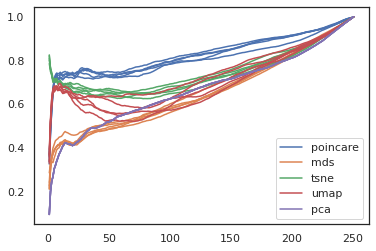

In [263]:
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [262]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.60, 0.02
mds 0.37, 0.02
tsne 0.81, 0.01
umap 0.59, 0.02
pca 0.32, 0.00
Global
poincare 0.83, 0.01
mds 0.67, 0.01
tsne 0.75, 0.01
umap 0.72, 0.02
pca 0.69, 0.00


# 
# 
# 

### Poincaré distances hyperboliques 

In [ ]:
for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")

### MDS

In [ ]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [ ]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative']:#,'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")

### t-SNE

In [ ]:
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [ ]:
D = pairwise_distances(X_tsne)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")

### UMAP

In [ ]:
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [ ]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")

### PCA

In [ ]:
X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [ ]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")

## Compare scores for clustering

In [ ]:
if remove_outliers:
    df_noothers = df_embedding[no_outliers]
if remove_others:
    df_noothers = df_noothers[df_embedding[true_col]!=other]
        
print(df_embedding.shape, df_noothers.shape)

for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

    ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

    if clust_meth == "poincare":
        D = model.distances
        Qlocal, Qglobal, Kmax = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
    else:
        D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
        Qlocal, Qglobal, Kmax = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)

    corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
    df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
    df_results = df_results.append(df)
    print(clust_meth + ": " + f"{ARI:.2f} " + f"{FMS:.2f} " + f"{corr.correlation:.2f} " + f"{Qlocal:.2f} "+f"{Qglobal:.2f} ")
#print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

In [ ]:
print(df_results)

In [ ]:
clust_meth = "tsne"
k_neigh = 5
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]
Qlocalt, Qglobalt, Kmaxt, df_q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5, my_metric = "cosine")
print(Qlocalt, Qglobalt)

In [ ]:
df_q

In [ ]:
clust_meth = "umap"
k_neigh = 5
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]
Qlocal, Qglobal, Kmax, df_qumap = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)
print(Qlocal, Qglobal)

In [ ]:
df_qumap

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.legend()
#plt.show()

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [ ]:
plt.scatter(X_umap[:,0], X_umap[:,1])

In [ ]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
model = PoincareMaps(poincare_coord)
model.get_distances()
clust_meth = "poincare"
k_neigh = 5
Qlocalp, Qglobalp, Kmaxp, df_qumapoin = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
print(Qlocalp, Qglobalp)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.plot(df_qumapoin.Qnx, label="pm")
plt.legend()

In [ ]:
print(Qlocal, Qglobal)
print(Qlocalt, Qglobalt)

In [ ]:

plt.plot(df_qumap.Qnx, label="umap")
plt.legend()

In [ ]:
fig = px.strip(df_results, x='method', y='ARI', color = "true_col")
fig.show()

In [ ]:
fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['corr'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qglobal'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qlocal'])
fig.show()

# Plots

## PoincaréMSA

In [ ]:
    fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=globin_palette,
                                 #title = title, 
                                 fontsize = 11)
    fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

## MDS

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding["clust_mds"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

## tSNE

In [ ]:

    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding["clust_tsne"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

## UMAP

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding["clust_umap"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## PCA

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding["clust_pca"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )


    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

In [244]:

    
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()